In [ ]:
import scanpy as sc
from torch.utils import data
import torch
import torch.optim as optim
import warnings

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
from scInferCode.model import *
from scInferCode.utils import *

In [ ]:
rna = sc.read_h5ad('./scInferData/BreastTask/rna.h5ad')
protein = sc.read_h5ad('./scInferData/BreastTask/protein.h5ad')

In [ ]:
sample_df = make_paired_samples(rna, protein)

Counts of all celltype:
              count
celltype          
macrophage     130
monocyte       130
epithelial     139
mesenchymal    131
neg_samples:60000, pos_samples:60000


In [ ]:
train_dataset, valid_dataset, rna_df, protein_df = make_scInfer_dataset(rna, protein, sample_df, rna_vars='highly_variable', protein_vars='importance', test_size=0.3, random_state=2024)

In [ ]:
input_size = train_dataset.get_size()
batch_size = 512
hidden_size = 256
embedding_size = 32
num_epochs = 100
margin = 1.0
learning_rate = 0.001
patience=20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = ContrastiveNetwork(input_size, hidden_size, embedding_size).to(device)
criterion = ContrastiveLoss(margin)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size, shuffle=False)

In [ ]:
input_size

{'protein': 127, 'rna': 2529}

In [ ]:
device

device(type='cuda')

Training:  27%|██▋       | 27/100 [06:52<18:35, 15.28s/epoch, train_loss=0.0000069936, test_loss=0.0000107937, lr=0.000729]

Early stopping at epoch 27. Best Test Loss: 0.000009


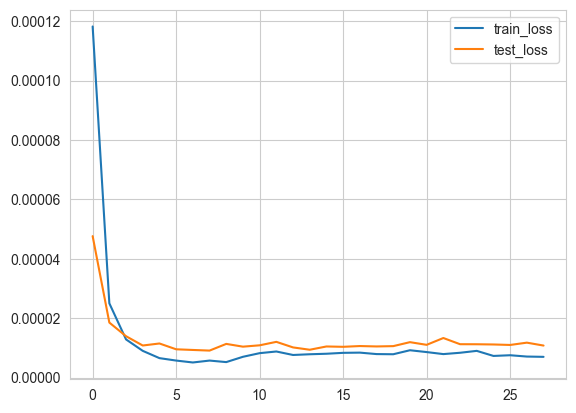

In [ ]:
model = train_embeddings(num_epochs, optimizer, device, model, criterion, train_loader, test_loader,patience=patience, plot_line=True)

In [ ]:
model_path = f'./scInferData/ModelParams/BreastTaskEmb.pth'

In [ ]:
# torch.save(model.state_dict(), model_path)

In [ ]:
model = ContrastiveNetwork(input_size, hidden_size, embedding_size).to(device)

In [ ]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
model.eval()

ContrastiveNetwork(
  (protein_branch): Sequential(
    (0): Linear(in_features=127, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (rna_branch): Sequential(
    (0): Linear(in_features=2529, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
)

In [ ]:
rna_em_ann, protein_em_ann = make_embeddings(model, device, rna_df, protein_df, rna, protein, celltype = 'celltype')

In [ ]:
rna_em_ann.write('./scInferData/BreastTask/rna_embeddings.h5ad')
protein_em_ann.write('./scInferData/BreastTask/protein_embeddings.h5ad')